## Demo Notebook: Behavior clustering

In [ ]:
import sys
sys.path.append('/Users/annateruel/socialhierarchy/code/')

from behavioral_clustering import sample_frames, load_features,run_umap, train_embedding_model, predict_embeddings, plot_umap_embedding, map_density

In [ ]:
sp_frames = sample_frames(directory='/Users/annateruel/Desktop/features',
                          file_format='csv',
                          frames_total = 100000)

In [ ]:
embedding = run_umap(sp_frames)

In [ ]:
train_embedding_model(embedding, sp_frames, save_model=True,
                      save_path='/Users/annateruel/Desktop/embedding_model.h5')

In [ ]:
plot_umap_embedding(embedding, save=True, save_dir= '/Users/annateruel/Desktop', format='png')

In [ ]:
map_density(embedding, sigma= 4, percentile=40, cmap='OrRd', save=True, save_dir='/Users/annateruel/Desktop', format='svg')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def map_variable_by_cluster(embedding,
                             variable,
                             var_name='social_distance',
                             agg_func=np.mean,
                             bins=200,
                             sigma=3.5,
                             percentile=30,
                             contour_smoothing=3,
                             cmap='plasma',
                             save=False,
                             save_dir=None,
                             format='svg'):
    """
    Plot the average value of a variable over UMAP clusters using watershed segmentation.
    
    Args:
        embedding (np.ndarray): 2D UMAP embedding (frames x 2).
        variable (np.ndarray): Array of same length as embedding, e.g. social distance.
        var_name (str): Label for the colorbar.
        agg_func (function): Aggregation function (np.mean, np.median, etc.).
        bins, sigma, percentile: Passed to map_density().
        contour_smoothing (int): Upsample factor for smoother contours.
        cmap (str): Colormap for the overlay.
        save (bool): Whether to save the figure.
        save_dir (str): Save location.
        format (str): Image format.
    
    Returns:
        cluster_map (np.ndarray): 2D array with variable values per cluster region.
    """
    # Step 1: Get watershed clusters
    labeled_map, density_map, xe, ye = map_density(
        embedding, bins=bins, sigma=sigma, percentile=percentile,
        plot=False
    )

    # Step 2: Assign each point to its cluster bin
    xi = np.digitize(embedding[:, 0], xe) - 1
    yi = np.digitize(embedding[:, 1], ye) - 1

    cluster_values = {}
    for x, y, val in zip(xi, yi, variable):
        if 0 <= x < labeled_map.shape[0] and 0 <= y < labeled_map.shape[1]:
            label = labeled_map[x, y]
            if label > 0:
                cluster_values.setdefault(label, []).append(val)

    # Step 3: Fill 2D cluster map with average values
    cluster_map = np.full_like(labeled_map, np.nan, dtype='float')
    for label, vals in cluster_values.items():
        cluster_map[labeled_map == label] = agg_func(vals)

    # Step 4: Plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # Smoothed contours
    labeled_map_up = zoom(labeled_map, contour_smoothing, order=0)
    extent = [xe[0], xe[-1], ye[0], ye[-1]]

    # Heatmap of variable
    im = ax.imshow(cluster_map.T, origin='lower', extent=extent, cmap=cmap)

    # Overlay contours
    ax.contour(
        labeled_map_up.T,
        levels=np.arange(1, np.max(labeled_map) + 1),
        colors="black",
        linewidths=2,
        origin="lower",
        extent=extent,
        alpha=0.8
    )

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label(var_name, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    ax.axis('off')

    if save and save_dir:
        filepath = f"{save_dir}/clustered_{var_name}_heatmap.{format}"
        plt.savefig(filepath, dpi=300, format=format, bbox_inches='tight', pad_inches=0.5)
        print(f"Saved to {filepath}")

    plt.show()
    return cluster_map

In [ ]:
features=load_features('/Users/annateruel/Desktop/features/', file_format='csv')
map_variable_by_cluster(
    embedding=embedding,
    variable=features['avg_centroid_distance'],
    var_name='Social Distance (z)',
    cmap='plasma',
    save=True,
    save_dir='/Users/annateruel/Desktop',
    format='svg'
)

In [17]:
def hierarchical_clustering(embedding, labeled_map, xe, ye, method='ward', plot=True):
    """
    Perform hierarchical clustering on behavior clusters and optionally plot a dendrogram.

    Args:
        embedding (np.ndarray): UMAP 2D embedding (n_frames x 2).
        labeled_map (np.ndarray): Watershed cluster map from density-based clustering.
        xe (np.ndarray): x-axis bin edges from histogram2d.
        ye (np.ndarray): y-axis bin edges from histogram2d.
        method (str): Linkage method for hierarchical clustering (default 'ward').
        plot (bool): Whether to plot the dendrogram.

    Returns:
        Z (np.ndarray): The linkage matrix used to construct the dendrogram.
    """
    x_idx = np.digitize(embedding[:, 0], xe) - 1
    y_idx = np.digitize(embedding[:, 1], ye) - 1

    valid = (
        (x_idx >= 0) & (x_idx < labeled_map.shape[0]) &
        (y_idx >= 0) & (y_idx < labeled_map.shape[1])
    )
    x_idx = x_idx[valid]
    y_idx = y_idx[valid]
    embedding_valid = embedding[valid]

    cluster_labels = labeled_map[x_idx, y_idx]

    valid_points = ~np.isnan(cluster_labels) & (cluster_labels > 0)
    labels = cluster_labels[valid_points].astype(int)
    embedding_valid = embedding_valid[valid_points]
    unique_labels = np.unique(labels)
    centroids = np.array([
        embedding_valid[labels == lbl].mean(axis=0)
        for lbl in unique_labels
    ])

    Z = linkage(centroids, method=method)

    if plot:
        plt.figure(figsize=(20, 15))
        dendrogram(Z, labels=unique_labels)
        plt.title("Hierarchical Clustering of Behavioral Clusters")
        plt.xlabel("Cluster")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()

    return Z,  cluster_labels

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.ndimage import center_of_mass
from scipy.stats import percentileofscore
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy


def compute_transition_matrix(cluster_labels, n_clusters):
    """
    Computes the normalized transition matrix between behavioral clusters.

    Args:
        cluster_labels (np.ndarray): Array of cluster labels over time.
        n_clusters (int): Number of clusters (assumes labels from 1 to n).

    Returns:
        np.ndarray: Normalized transition probability matrix (shape: n_clusters x n_clusters).
    """
    transition_matrix = np.zeros((n_clusters, n_clusters))

    for (i, j) in zip(cluster_labels[:-1], cluster_labels[1:]):
        if i > 0 and j > 0:  # skip background if any
            transition_matrix[i - 1, j - 1] += 1

    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums != 0)
    return transition_matrix


def test_transition_significance(cluster_labels, n_clusters, n_permutations=1000, seed=42):
    """
    Computes p-values for each transition using permutation testing.

    Args:
        cluster_labels (np.ndarray): Array of cluster labels over time.
        n_clusters (int): Number of clusters.
        n_permutations (int): Number of permutations.
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Matrix of p-values for each transition (same shape as transition matrix).
    """
    np.random.seed(seed)
    observed = compute_transition_matrix(cluster_labels, n_clusters)
    permuted = np.zeros((n_permutations, n_clusters, n_clusters))

    for i in range(n_permutations):
        shuffled = np.random.permutation(cluster_labels)
        permuted[i] = compute_transition_matrix(shuffled, n_clusters)

    pvals = np.ones((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            null_dist = permuted[:, i, j]
            obs = observed[i, j]
            pvals[i, j] = 1 - (percentileofscore(null_dist, obs, kind='mean') / 100)
    return pvals


def plot_transition_matrix_with_dendrogram(cluster_labels, n_clusters, method='ward', annotate_significance=True):
    """
    Plots the behavioral transition matrix with hierarchical clustering and significance annotation.

    Args:
        cluster_labels (np.ndarray): Array of cluster labels over time.
        n_clusters (int): Number of clusters (labels must be 1-indexed).
        method (str): Linkage method for hierarchical clustering.
        annotate_significance (bool): If True, annotate transitions with p < 0.05 using '*'.
    """
    T = compute_transition_matrix(cluster_labels, n_clusters)

    # Hierarchical clustering on transition structure (e.g., rows as features)
    linkage_matrix = linkage(T, method=method)
    ordered_indices = leaves_list(linkage_matrix)

    T_sorted = T[ordered_indices][:, ordered_indices]

    if annotate_significance:
        pvals = test_transition_significance(cluster_labels, n_clusters)
        pvals_sorted = pvals[ordered_indices][:, ordered_indices]
        sig_mask = pvals_sorted < 0.05
    else:
        sig_mask = np.full_like(T_sorted, False)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        T_sorted,
        cmap="OrRd",
        annot=False,
        square=True,
        xticklabels=ordered_indices + 1,
        yticklabels=ordered_indices + 1,
        cbar_kws={'label': 'P(start → exit)'},
        ax=ax
    )

    # Add asterisks for significant transitions
    for i in range(n_clusters):
        for j in range(n_clusters):
            if sig_mask[i, j]:
                ax.text(j + 0.5, i + 0.5, '*', color='white', ha='center', va='center', fontsize=12)

    ax.set_xlabel("exit behavior", fontsize=12)
    ax.set_ylabel("start behavior", fontsize=12)
    ax.set_title("Behavioral Transition Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

    return T, ordered_indices, linkage_matrix

In [20]:
labeled_map, density_map, xe, ye = map_density(
    embedding, bins=200, sigma=3.5, percentile=30, plot=False
)

Computing density map...


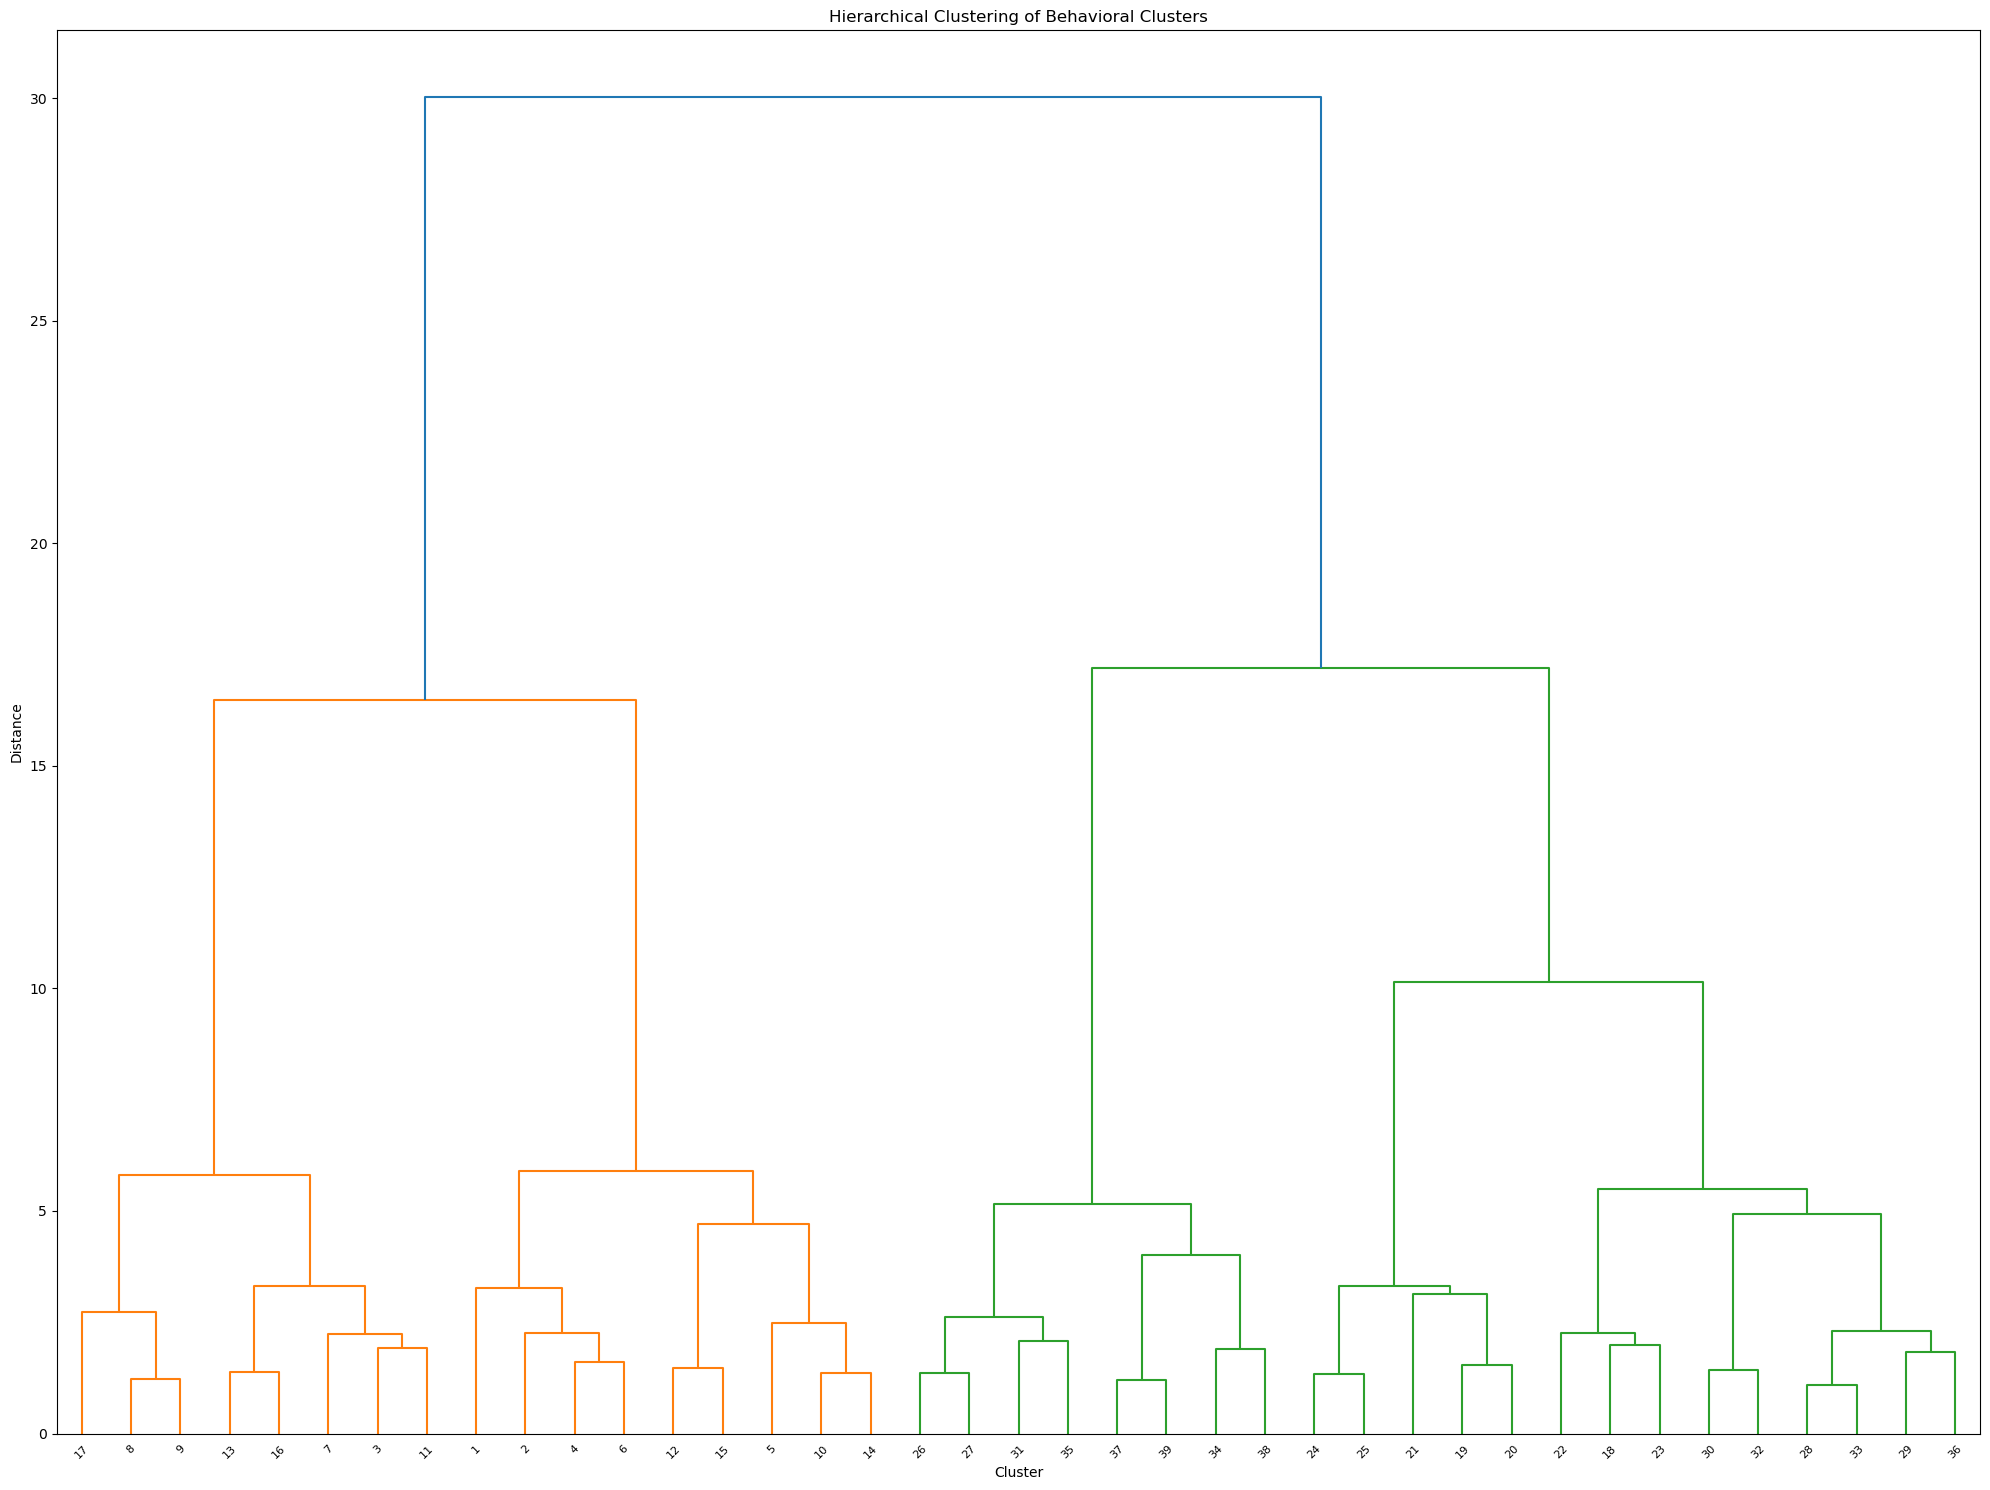

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [21]:
Z, cluster_labels = hierarchical_clustering(embedding, labeled_map, xe, ye)
T, order, Z = plot_transition_matrix_with_dendrogram(cluster_labels, n_clusters=int(cluster_labels.max()))